### Setup

In [1]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [2]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from irrep_bounds import *
from coset_bounds import model_dist_res
%load_ext autoreload
%autoreload 2

Syntax warning: Unbound global variable in /usr/share/gap/pkg/browse/PackageIn\
fo.g:73
  if not IsKernelExtensionAvailable("Browse", "ncurses") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/edim/PackageInfo\
.g:60
  if not IsKernelExtensionAvailable("EDIM","ediv") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^


In [3]:

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# MODEL_DIR = '2024-08-16_22-53-29_SL2_5_MLP3_256'
# MODEL_DIR = '2024-08-14_21-24-30_gapS_5_'
MODEL_DIR = '2024-09-18_23-59-00_gapS5_MLP2_128_wd2e-4_ubias'
# MODEL_DIR = '2024-09-18_05-50-44_gapS5_MLP2_128_wd1e-5_ubias'
# MODEL_DIR = '2024-09-16_05-00-33_gapS5_MLP2_128_adamw_wd1'
# MODEL_DIR = '2024-09-13_03-46-47_gapS5_256_wd1e-3'
# MODEL_DIR = '2024-09-13_21-56-07_gapS5_MLP2_256_adamw_wd1'
# MODEL_DIR = '2024-08-27_16-32-46_Dic30_MLP3_128'
# MODEL_DIR = '2024-08-27_23-16-05_F11_MLP3_256'
# MODEL_DIR = '2024-09-02_18-17-20_smallgrp_54_8_MLP3_256_0_6'
# MODEL_DIR = '2024-09-05_15-22-58_smallgrp_54_8_MLP3_1024_0_6'
# MODEL_DIR = '2024-09-05_20-47-44_smallgrp_54_8_MLP3_1024_0_6_wd1e-6'
# MODEL_DIR = '2024-09-02_18-51-29_smallgrp_96_71_MLP3_256_0_6'
# MODEL_DIR = '2024-09-03_17-28-20_smallgrp_192_1025_MLP3_512_0_6'
# MODEL_DIR = '2024-09-03_21-09-07_Z_59_128'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir)
data = GroupData(params)
group = data.groups[0]

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: gapS(5)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


/home/wilson/Finite-groups/src/model_utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


In [4]:
loss_dict = test_loss(models[-1].to(device), data)

In [5]:

# instance = loss_dict['G0_acc'].argmax().item()
instance = loss_dict['G0_loss'].argmin().item()
# instance = (loss_dict['G0_acc'] > 0.999).nonzero()[11]
# instance = 2
print(loss_dict[f'G0_loss'][instance], loss_dict[f'G0_acc'][instance], instance)
model = models[-1][instance].to(device)

tensor(0.0306) tensor(1.) 12


In [34]:
norm12 = lambda A: A.norm(dim=0).max()  # max 2-norm along group dimension
# note: norm2inf in the correct one to use for both embed and unembed. bc of how the transposes work
norm2inf = lambda A: A.norm(dim=1).max()  # max 2-norm along neuron dimension
norm22 = lambda A: t.linalg.matrix_norm(A, ord=2)

ln, rn, un = model.get_neurons(True)
norm21(ln), norm21(rn), norm21(un), norm22(ln), norm22(rn), norm22(un)

(tensor(17.6622),
 tensor(17.6451),
 tensor(2.7431),
 tensor(93.6273),
 tensor(93.5545),
 tensor(9.5807))

In [35]:
norm2inf(un) * (norm2inf(ln - ln_ideal) + norm2inf(rn - rn_ideal)), norm2inf(un - un_ideal) * (norm2inf(ln) + norm2inf(rn))

(tensor(0.7908), tensor(8.4623))

In [7]:
irreps, irrep_idx_dict = get_neuron_irreps(model, group, norm_thresh=1)

In [8]:
sign = irreps['1d-0'].squeeze(-1)
sign = sign / sign.norm()
proj = t.eye(120) - sign @ sign.T

In [9]:
vecs = get_neuron_vecs(model, group, irreps, irrep_idx_dict, strict=False)

1d-0
1-r2 90th percentile 0.0
a variance: 0.0
b variance: 1.0
c variance: 1.0
d variance: 0.0
a vs d tensor(0.)
2 0.0
2 0.0
b has 2 clusters with total loss 0.0
c has 2 clusters with total loss 0.0
b_parts [[0, 1]]
c_parts [[0, 1]]
a_mean tensor([1.])
b_mean tensor([[-1.],
        [ 1.]])
c_mean tensor([[-1.],
        [ 1.]])
b_labels tensor([1, 1, 0, 0], dtype=torch.int32)
c_labels tensor([0, 1, 0, 1], dtype=torch.int32)
coef diff tensor(2.2553e-06)
dict_keys(['1d-0'])

4d-0
5d-0
6d-0
5d-1
4d-1
1-r2 90th percentile 0.0003428685595281422
a variance: 1.0489316792927639e-07
b variance: 0.9999996423721313
c variance: 0.9999998211860657
d variance: 8.395662121074565e-08
a vs d tensor(4.6905e-07)
2 2250.027587890625
3 1500.055419921875
4 750.0839233398438
2 2250.03955078125
3 1500.080322265625
4 750.121337890625
b has 5 clusters with total loss 0.11231588572263718
c has 5 clusters with total loss 0.16189686954021454
b_parts [[0, 1, 2, 3, 4]]
c_parts [[0, 1, 2, 3, 4]]
a_mean tensor([ 0.3751,

In [10]:
coef, A_norm, a_mean, b_mean, c_mean, b_labels, c_labels, b_parts, c_parts = vecs['4d-1']

In [11]:
ideal = get_idealized_model(model, irreps, irrep_idx_dict, vecs)

1d-0
l diff tensor(1.8304e-05)
r diff tensor(1.3973e-05)
u diff tensor(0.0017)
4d-1
l diff tensor(2.6048e-05)
r diff tensor(2.6962e-05)
u diff tensor(0.0022)
total
l diff tensor(3.9443e-05)
r diff tensor(3.9808e-05)
u diff tensor(0.0023)


In [12]:
norm2inf = lambda A: A.norm(dim=1, p=2).max()

In [ ]:
norm2inf(un) * norm12

In [13]:
ln, rn, un = model.get_neurons(True)
ln_ideal, rn_ideal, un_ideal = ideal.get_neurons(True)

In [14]:
embed_diff_mean = 0
for i in range(len(group)):
    for j in range(len(group)):
        embed_diff_mean += (t.maximum(t.zeros_like(ln[i]), ln[i] + rn[j]) - t.maximum(t.zeros_like(ln[i]), ln_ideal[i] + rn_ideal[j])).norm()
embed_diff_mean /= len(group)**2
embed_diff_mean * t.linalg.matrix_norm(un_ideal, ord=2)

tensor(1.0330)

In [178]:
embed_mean = 0
for i in range(len(group)):
    for j in range(len(group)):
        embed_mean += t.maximum(t.zeros_like(ln[i]), ln[i] + rn[j]).norm()
embed_mean /= len(group)**2
# ((un - un_ideal) @ embed_mean).norm()
embed_mean * t.linalg.matrix_norm(un - un_ideal, ord=2)

tensor(7.2014)

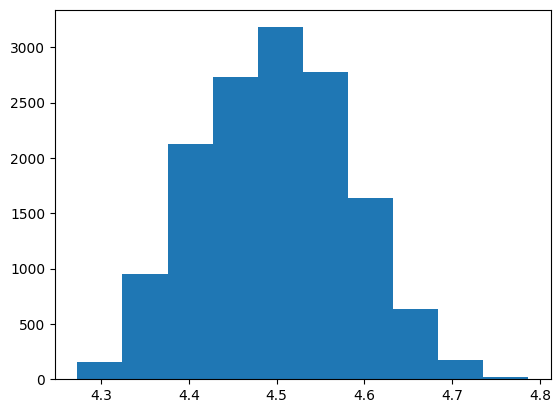

In [16]:
diff_infs = []
u_norm = norm2inf(un_ideal)
u_diff_norm = norm2inf(un_ideal - un)
for i, j in product(range(len(group)), repeat=2):
    diff_infs.append(
        u_norm * (t.maximum(t.zeros_like(ln[i]), ln[i] + rn[j]) - t.maximum(t.zeros_like(ln[i]), ln_ideal[i] + rn_ideal[j])).norm().item()
        + u_diff_norm * t.maximum(t.zeros_like(ln[i]), ln[i] + rn[j]).norm().item()
    )
plt.hist(diff_infs)
plt.show()

In [179]:
t.linalg.matrix_norm(un - un_ideal)

tensor(1.3876)

In [180]:
(un - un_ideal).max()

tensor(0.0944)

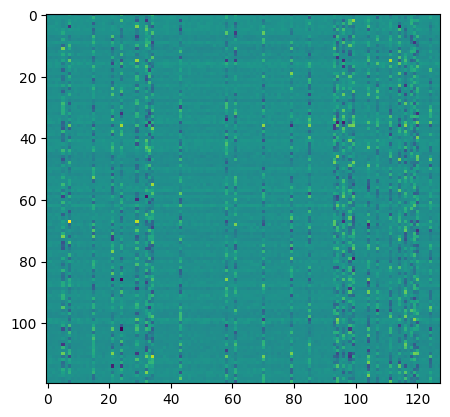

In [181]:
plt.imshow(un - un_ideal)

In [182]:
model_dist(model, ideal)

l diff tensor(0.1433)
r diff tensor(0.1450)
u diff tensor(0.4098)
l norm tensor(17.6622)
r norm tensor(17.6451)
u norm tensor(9.5807)
u diff term tensor(14.4091)
lr diff term tensor(2.7619)


tensor(17.1710)

In [183]:
model_dist2(model, ideal)

tensor(78.4520)

In [30]:
ubias = model.unembed_bias.detach().T

In [31]:
(proj @ ubias).norm()**2 / ubias.norm()**2

tensor(0.0165)

In [33]:
(proj @ ubias).max()

tensor(0.4138)

In [187]:
ubias.norm()

tensor(9.6728)

In [28]:
(proj @ (un - un_ideal)).norm()**2 / (un - un_ideal).norm()**2

tensor(0.9972)

In [97]:
d = model_dist_inf(model, ideal).item()
d

9.172009468078613

In [26]:
out = ideal(t.tensor([[2, 2]])).flatten()
out
# ((out.max() - out) > d).float().mean()

tensor([14.7863,  0.3687,  3.5531,  5.7806,  5.7806,  6.1901,  0.3691, -3.2249,
         5.7809, -8.6367, -2.8153,  2.5965,  5.7809, -2.8153,  6.1904,  2.5965,
         8.4179, -2.8153, -8.6367,  2.5965,  2.5965, -2.8153, -2.8153, -3.2249,
         3.2806, -0.3133,  2.8711, -5.7251, -5.7251,  5.5081,  5.7809, -8.6367,
        -2.5407, -3.2249, -0.3133, -2.8153,  0.3691,  2.5965,  8.6925, -2.8153,
         0.0963,  2.5965, -3.2249, -2.8153, -5.7251,  2.5965, -0.3133, -8.6367,
         5.7809, -8.6367,  0.3691, -3.2249,  2.5965, -2.8153,  6.4629,  2.8690,
         8.9649, -2.5429,  0.3687,  8.6904,  8.6907, -5.7269,  0.3691, -0.3151,
         2.5965,  0.0945, -5.7269, -0.3151, -3.2249, -5.7269, -8.6367, -0.3151,
        -2.5407, -0.3133,  8.6925, -5.7251,  0.0963, -0.3133,  8.9649,  0.3687,
         6.4647,  5.7806,  8.6922,  0.3687,  0.3691, -3.2249,  2.8711, -8.6367,
        -5.7251,  2.5965,  2.5965, -8.6367, -5.7251, -3.2249, -0.3133, -2.8153,
        -3.2249, -2.8153, -2.8153,  2.59

In [27]:
out.topk(k=2).values[0] - out.topk(k=2).values[1]

tensor(5.8214, grad_fn=<SubBackward0>)

In [158]:
loss = lambda x: -t.log(t.exp(x[0]) / t.exp(x).sum())

In [159]:
max_loss = 0
for _ in tqdm(range(1000000)):
    err = t.randn_like(out)#.sign() * 11
    err = err / err.norm() * 8.3
    max_loss = max(max_loss, loss(out + err).item())
loss(out).item(), max_loss

100%|██████████| 1000000/1000000 [00:20<00:00, 49350.99it/s]


(0.0010046042734757066, 0.0495346337556839)

In [31]:
model = model.fold_linear()
# ideal = ideal.fold_linear()
ln1, rn1, un1 = model.get_neurons()
ln2, rn2, un2 = ideal.get_neurons()
ln1, rn1, un1 = ln1[:,:, part_idxs], rn1[:,:, part_idxs], un1[:,:, part_idxs]
ln2, rn2, un2 = ln2[:,:, part_idxs], rn2[:,:, part_idxs], un2[:,:, part_idxs]
ln_noise = t.randn_like(ln1)
ln_noise = ln_noise / ln_noise.norm() * (ln1 - ln2).norm()
rn_noise = t.randn_like(rn1)
rn_noise = rn_noise / rn_noise.norm() * (rn1 - rn2).norm()
un_noise = t.randn_like(un1)
un_noise = un_noise / un_noise.norm() * (un1 - un2).norm()
ln3, rn3, un3 = ln2 + ln_noise, rn2 + rn_noise, un2 + un_noise

NameError: name 'part_idxs' is not defined

In [15]:
un1.norm(), un2.norm() 

(tensor(27.0105), tensor(26.9070))

In [20]:
noise_model = copy.deepcopy(model)
noise_model.embedding_left = nn.Parameter(ln3)
noise_model.embedding_right = nn.Parameter(rn3)
noise_model.unembedding = nn.Parameter(un3.mT)

In [21]:
test_loss(noise_model, data)

{'G0_loss': tensor([0.2678]),
 'G0_loss_std': tensor([0.1247]),
 'G0_acc': tensor([1.])}

In [57]:
test_loss(noise_model, data), test_loss(ideal, data),  test_loss(model, data)

({'G0_loss': tensor([0.1731]),
  'G0_loss_std': tensor([0.1883]),
  'G0_acc': tensor([0.9990])},
 {'G0_loss': tensor([0.1231]),
  'G0_loss_std': tensor([0.0968]),
  'G0_acc': tensor([1.])},
 {'G0_loss': tensor([0.0296]),
  'G0_loss_std': tensor([0.0080]),
  'G0_acc': tensor([1.])})

In [29]:
model_dist2(model, ideal)#, irrep_idx_dict, vecs)

tensor(151.1256)

In [28]:
sorted(dist.tolist())

TypeError: 'float' object is not iterable

In [44]:
model_dist_parted(model, ideal, irrep_idx_dict, vecs)

1d-0
l diff tensor(0.1423)
r diff tensor(0.1301)
u diff tensor(0.1309)
l norm tensor(37.6832)
r norm tensor(37.6227)
u norm tensor(8.6710)
12.21975326538086
4d-1
l diff tensor(0.5003)
r diff tensor(0.4084)
u diff tensor(2.0580)
l norm tensor(37.3536)
r norm tensor(37.2156)
u norm tensor(6.8900)
159.40463256835938
4d-1
l diff tensor(0.)
r diff tensor(0.)
u diff tensor(1.4427)
l norm tensor(8.8416)
r norm tensor(8.7849)
u norm tensor(1.4427)
25.430316925048828


197.05470275878906

In [32]:
_, _, un1 = model.get_neurons(True)
_, _, un2 = ideal.get_neurons(True)

In [43]:
((un1 - un2).norm(dim=0))[part_idxs].max() #/ un1.norm(dim=0))[part_idxs]

tensor(0.5175)

In [61]:
(ideal.unembedding - model.unembedding)[0].norm(dim=1)

tensor([3.9519e-01, 1.9263e+00, 2.7491e-02, 0.0000e+00, 2.0834e-03, 2.9060e-02,
        3.0195e-01, 4.8089e-01, 1.3822e+00, 2.9299e-01, 5.6391e-04, 1.7642e+00,
        4.3101e-01, 2.3929e-01, 3.8706e-04, 1.8467e-01, 3.0984e-01, 6.9950e-03,
        1.4025e+00, 1.1464e-01, 0.0000e+00, 2.8585e-01, 1.7904e+00, 2.1838e-01,
        1.2053e-04, 4.7698e-01, 1.7771e+00, 4.6449e-02, 1.2915e-04, 1.2651e-01,
        4.9187e-03, 1.3275e-01, 1.5971e+00, 8.5666e-02, 4.7559e-01, 0.0000e+00,
        9.9433e-02, 3.8776e-01, 1.8291e+00, 8.8188e-01, 9.8395e-02, 1.2016e-04,
        0.0000e+00, 4.6339e-01, 3.0990e-02, 1.6035e-02, 4.7704e-01, 1.9921e-03,
        4.4426e-01, 3.2006e-01, 2.2652e-01, 1.8414e+00, 1.0796e+00, 1.7409e-02,
        8.8652e-02, 4.2277e-01, 1.8674e+00, 1.2950e-03, 4.2510e-01, 4.7889e-01,
        1.8257e+00, 8.6694e-02, 8.8028e-02, 4.6159e-01, 1.5211e+00, 1.6752e+00,
        1.5701e-02, 1.8629e+00, 4.4153e-01, 3.2458e-01, 1.3208e-03, 4.6803e-02,
        0.0000e+00, 1.5985e-03, 1.2449e+

In [43]:
ideal.unembedding[0, part_idxs[4], :15], model.unembedding[0, part_idxs[4], :15]

(tensor([-0.9858,  0.2464,  0.2464,  0.2464,  0.2464, -0.9858, -0.9858,  0.2464,
          0.2464,  0.2464,  0.2464, -0.9858,  0.2464,  0.2464,  0.2464],
        grad_fn=<SliceBackward0>),
 tensor([-0.9570,  0.1998,  0.2163,  0.2846,  0.2874, -1.0399, -1.0421,  0.2721,
          0.2724,  0.2598,  0.1809, -0.9766,  0.2939,  0.1614,  0.2129],
        grad_fn=<SliceBackward0>))

In [37]:
irrep_idx_dict['4d-1'].index(88)

65

In [38]:
b_labels[65], c_labels[65]

(tensor(5, dtype=torch.int32), tensor(5, dtype=torch.int32))

In [12]:
from coset_bounds import model_dist as cdist

In [15]:
cdist(model, ideal)

l diff tensor(0.5003)
r diff tensor(0.4084)
u diff tensor(2.0830)
l norm tensor(37.6832)
r norm tensor(37.6227)
u norm tensor(8.9174)


tensor(164.9650)

In [136]:
ideal.unembedding[0,5,:].norm(), model.unembedding[0,5,:].norm()

(tensor(0., grad_fn=<LinalgVectorNormBackward0>),
 tensor(0.1013, grad_fn=<LinalgVectorNormBackward0>))

In [148]:
(ideal.unembedding[0] - model.unembedding[0]).norm(dim=1).argmax()

tensor(88)

In [150]:
ideal.unembedding[0,88].norm(), model.unembedding[0,88].norm()

(tensor(0., grad_fn=<LinalgVectorNormBackward0>),
 tensor(1.2796, grad_fn=<LinalgVectorNormBackward0>))

In [154]:
test_loss(ideal, data), test_loss(model, data)

({'G0_loss': tensor([0.1231]),
  'G0_loss_std': tensor([0.0968]),
  'G0_acc': tensor([1.])},
 {'G0_loss': tensor([0.0296]),
  'G0_loss_std': tensor([0.0080]),
  'G0_acc': tensor([1.])})

In [163]:
ideal(t.tensor([[10, 15]])).max()

tensor(15.5970, grad_fn=<MaxBackward1>)

In [173]:
irrep_model = copy.deepcopy(ideal)
irrep_name = '1d-0'
irrep_model.embedding_left.data = ideal.embedding_left[:,:,irrep_idx_dict[irrep_name]]
irrep_model.embedding_right.data = ideal.embedding_right[:,:,irrep_idx_dict[irrep_name]]
irrep_model.unembedding.data = ideal.unembedding[:,irrep_idx_dict[irrep_name]]

In [171]:
test_loss(irrep_model, data)

{'G0_loss': tensor([0.2198]),
 'G0_loss_std': tensor([4.2085e-07]),
 'G0_acc': tensor([1.])}

In [180]:
irrep_model(t.tensor([[11, 17]]))

tensor([[[-3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460,
          -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,
           3.8460,  3.8460, -3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,
           3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460,
          -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460, -3.8460,
           3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460,
          -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460,
          -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460,  3.8460, -3.8460, -3.8460,  3.8460,  3.8460,
          -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,  3.8460,
           3.8460, -3.8460, -3.8460,  3.8460,  3.8460, -3.8460, -3.8460,
           3.8460,  3.8460, -3.8460, -3.8460,  3.84

In [183]:
irrep_model.unembedding[0,:,:10]

tensor([[-0.5594,  0.5594,  0.5594, -0.5594, -0.5594,  0.5594,  0.5594, -0.5594,
         -0.5594,  0.5594],
        [-0.5598,  0.5598,  0.5598, -0.5598, -0.5598,  0.5598,  0.5598, -0.5598,
         -0.5598,  0.5598],
        [-0.0010,  0.0010,  0.0010, -0.0010, -0.0010,  0.0010,  0.0010, -0.0010,
         -0.0010,  0.0010]], grad_fn=<SliceBackward0>)